# Exercise 01
    by: Julian Smith
    date: 7/15/19

In [45]:
import warnings
warnings.filterwarnings('ignore')

from nltk.classify import accuracy
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import shap

import pandas as pd
import pickle

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

RANDOM_STATE = 90617

# 0.0 Loading the Data

In [2]:
# set default figure size for plots
rcParams['figure.figsize'] = 15,8

data = pd.read_csv('../data/exercise01.csv')
data.head(10)

,id,age,workclass_id,workclass_name,education_level_id,education_level_name,education_num,marital_status_id,marital_status_name,occupation_id,...,race_id,race_name,sex_id,sex_name,capital_gain,capital_loss,hours_week,country_id,country_name,over_50k
0,1,39,8,State-gov,10,Bachelors,13,5,Never-married,2,...,5,White,2,Male,2174,0,40,40,United-States,0
1,2,50,7,Self-emp-not-inc,10,Bachelors,13,3,Married-civ-spouse,5,...,5,White,2,Male,0,0,13,40,United-States,0
2,3,38,5,Private,12,HS-grad,9,1,Divorced,7,...,5,White,2,Male,0,0,40,40,United-States,0
3,4,53,5,Private,2,11th,7,3,Married-civ-spouse,7,...,3,Black,2,Male,0,0,40,40,United-States,0
4,5,28,5,Private,10,Bachelors,13,3,Married-civ-spouse,11,...,3,Black,1,Female,0,0,40,6,Cuba,0
5,6,37,5,Private,13,Masters,14,3,Married-civ-spouse,5,...,5,White,1,Female,0,0,40,40,United-States,0
6,7,49,5,Private,7,9th,5,4,Married-spouse-absent,9,...,3,Black,1,Female,0,0,16,24,Jamaica,0
7,8,52,7,Self-emp-not-inc,12,HS-grad,9,3,Married-civ-spouse,5,...,5,White,2,Male,0,0,45,40,United-States,1
8,9,31,5,Private,13,Masters,14,5,Never-married,11,...,5,White,1,Female,14084,0,50,40,United-States,1
9,10,42,5,Private,10,Bachelors,13,3,Married-civ-spouse,5,...,5,White,2,Male,5178,0,40,40,United-States,1


In [3]:
data.columns

Index(['id', 'age', 'workclass_id', 'workclass_name', 'education_level_id',
       'education_level_name', 'education_num', 'marital_status_id',
       'marital_status_name', 'occupation_id', 'occupation_name',
       'relationship_id', 'relationship_name', 'race_id', 'race_name',
       'sex_id', 'sex_name', 'capital_gain', 'capital_loss', 'hours_week',
       'country_id', 'country_name', 'over_50k'],
      dtype='object')

In [4]:
# converting all '?' to NaN
data = data.mask(data=='?', float('NaN'))

# counting null rows for deciding on impute vs. remove
null_counts = data.isnull().sum(axis=1)
print(f'{sum(null_counts.mask(null_counts > 0, 1))} rows with 1 or more null values, or {sum(null_counts.mask(null_counts > 0, 1))/len(data)*100}% of dataset.')

3620 rows with 1 or more null values, or 7.411653904426519% of dataset.


# Exploratory Data Analysis

In [5]:
# for use in easier subsetting later
num_vars = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_week', 'over_50k']
cat_vars = ['workclass_name', 'education_level_name', 'marital_status_name', 'occupation_name',
           'relationship_name', 'race_name', 'sex_name', 'country_name']
cat_vars_id = ['workclass_id', 'education_level_id', 'marital_status_id', 'occupation_id',
           'relationship_id', 'race_id', 'sex_id', 'country_id']

target = ['over_50k']

data[num_vars].describe()

,age,education_num,capital_gain,capital_loss,hours_week,over_50k
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,10.078089,1079.067626,87.502314,40.422382,0.239282
std,13.710510,2.570973,7452.019058,403.004552,12.391444,0.426649
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000


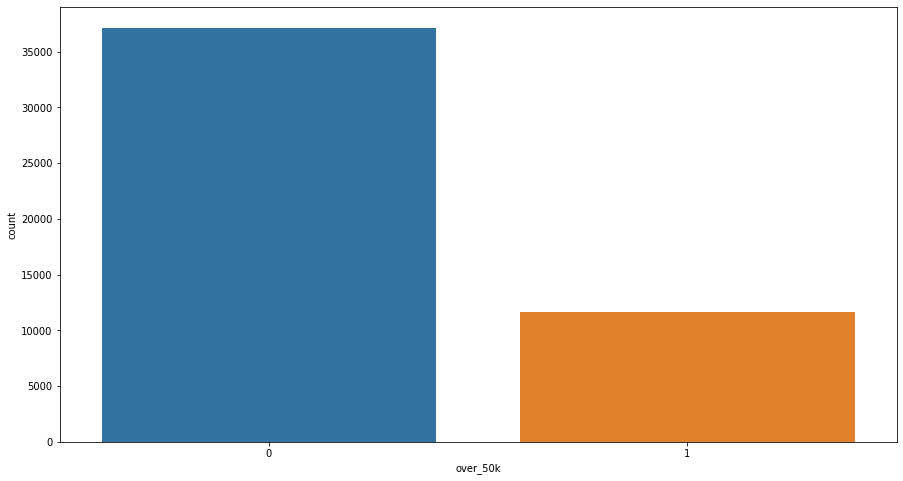

In [6]:
sns.countplot('over_50k', data=data)
plt.show()

# Analysis of Categorical Data

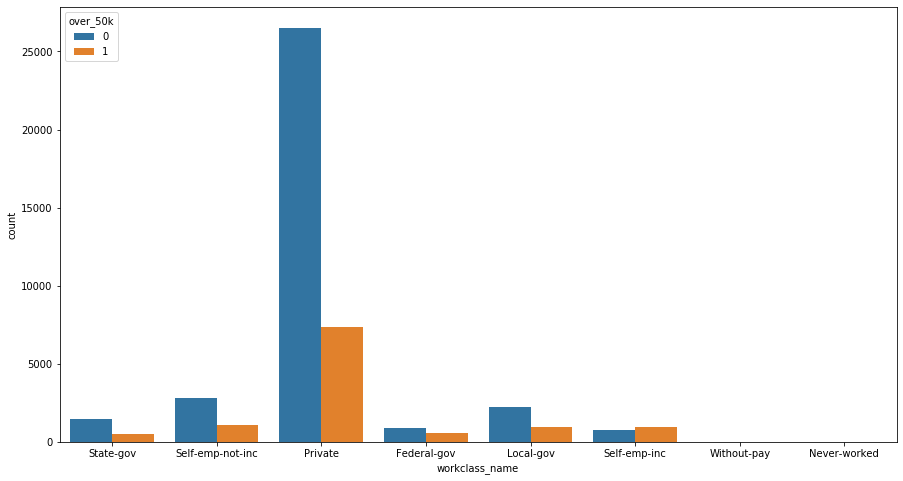

In [7]:
ax = sns.countplot('workclass_name', hue='over_50k', data=data)

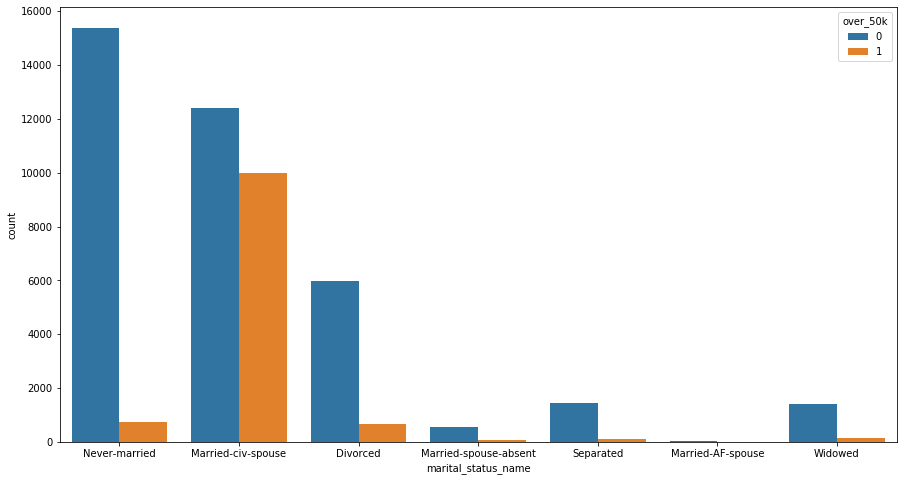

In [8]:
# Fairly clear that married individuals have a higher chance of making over 50k per year. 
# However, this may be a result from other factors
ax = sns.countplot('marital_status_name', hue='over_50k', data=data)

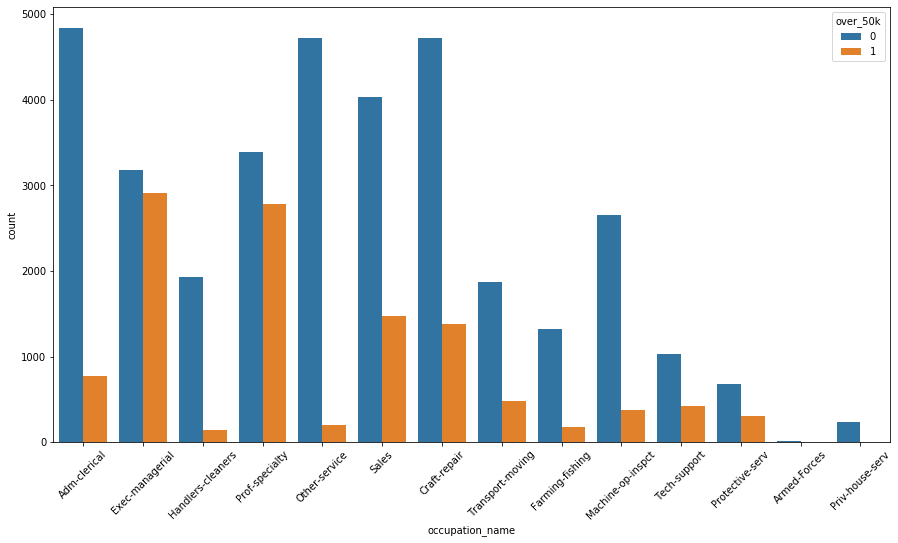

In [9]:
ax = sns.countplot('occupation_name', hue='over_50k', data=data)
for item in ax.get_xticklabels():
    item.set_rotation(45)

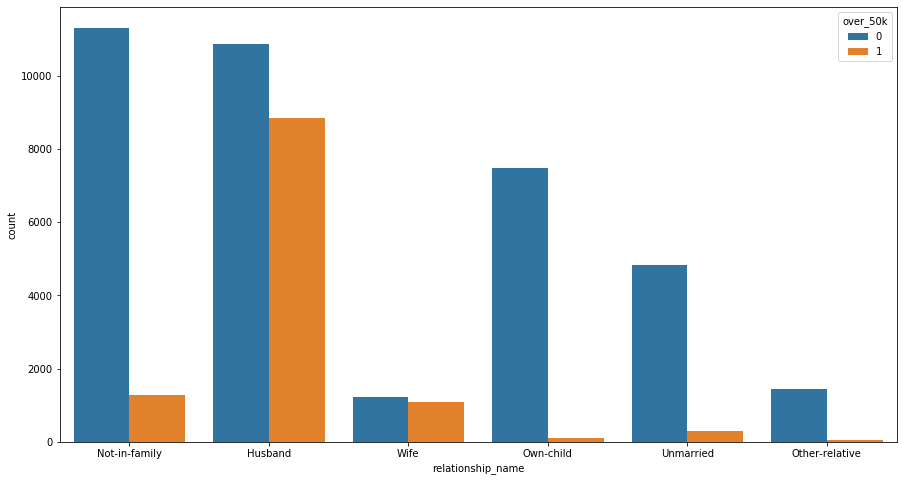

In [10]:
ax = sns.countplot('relationship_name', hue='over_50k', data=data)

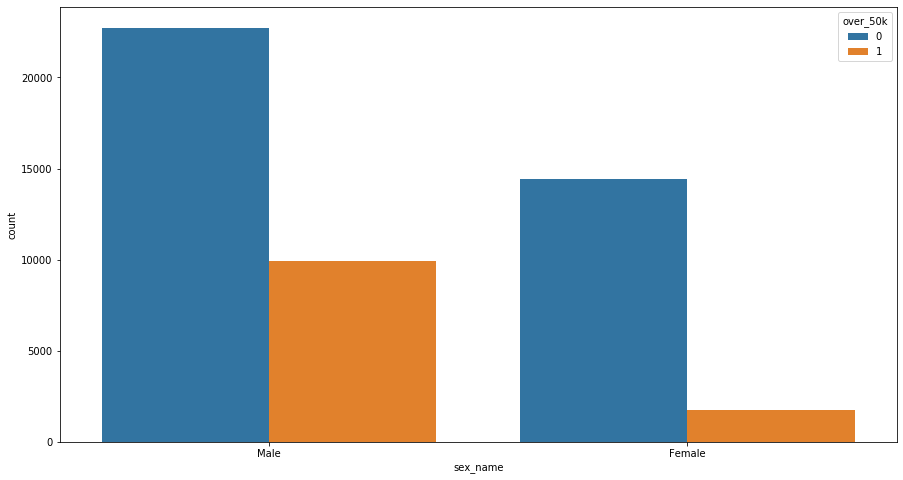

In [11]:
ax = sns.countplot('sex_name', hue='over_50k', data=data) # higher percentage of men making over 50k

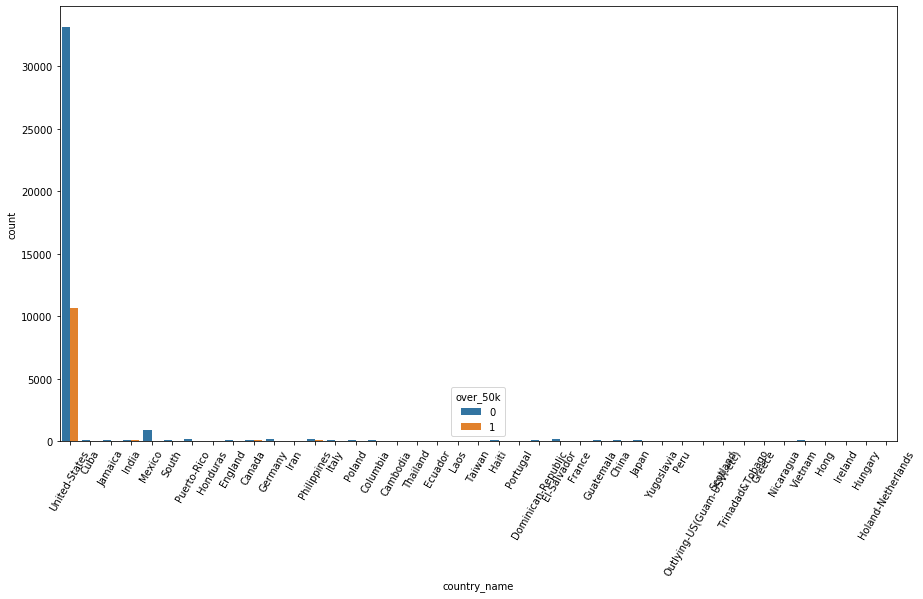

In [12]:
# data
ax = sns.countplot('country_name', hue='over_50k', data=data)
for item in ax.get_xticklabels():
    item.set_rotation(60)

In [13]:
# making new column for the US, non-US OECD high income, and non-US non-OECD high income
def label_country(row):
    # to be used in apply function later
    oecd_high_income = ['Austria', 'Belgium', 'Czech-Republic', 'Denmark', 'Estonia', 'Finland', 'France',
                   'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania',
                   'Luxembourg', 'Holand-Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
                   'Spain', 'Sweden', 'Switzerland', 'United-Kingdom', 'Israel', 'Japan', 'South', 'Canada', 'Australia',
                   'New-Zealand', 'Chile']
    
    if row['country_name'] == 'United-States':
        return 'US'
    if row['country_name'] in oecd_high_income:
        return 'non-US OECD'
    else:
        return 'non-US non-OECD'

data['country_label'] = data.apply(lambda row: label_country(row), axis=1)

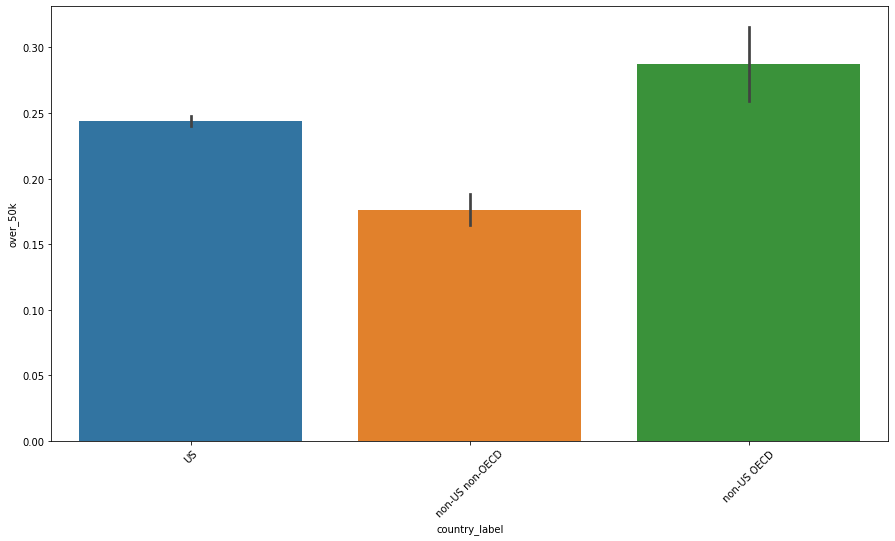

In [14]:
ax = sns.barplot(x="country_label", y="over_50k", data=data)
for item in ax.get_xticklabels():
    item.set_rotation(45)

# Analysis of Numeric Data

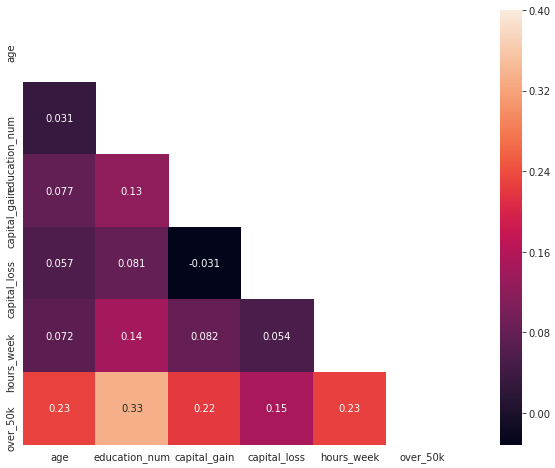

In [15]:
corr = data[num_vars].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.4, annot=True, square=True)

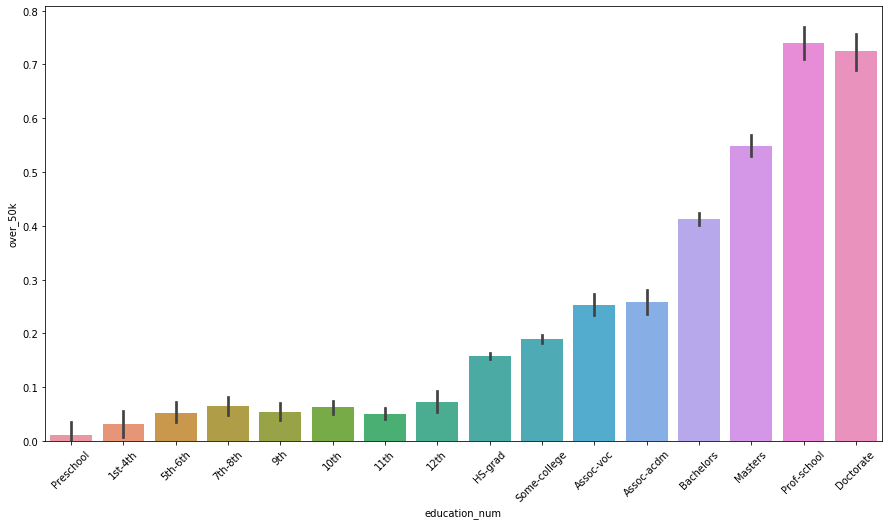

In [16]:
ax = sns.barplot(x="education_num", y="over_50k", data=data)
for item in ax.get_xticklabels():
    item.set_rotation(45)
    
# manually setting xticks to correspond with education level name
set_xticks = ax.set_xticklabels(['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th',
                   'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school', 
                    'Doctorate'])

# shows strong correlation between years of education and making over 50k

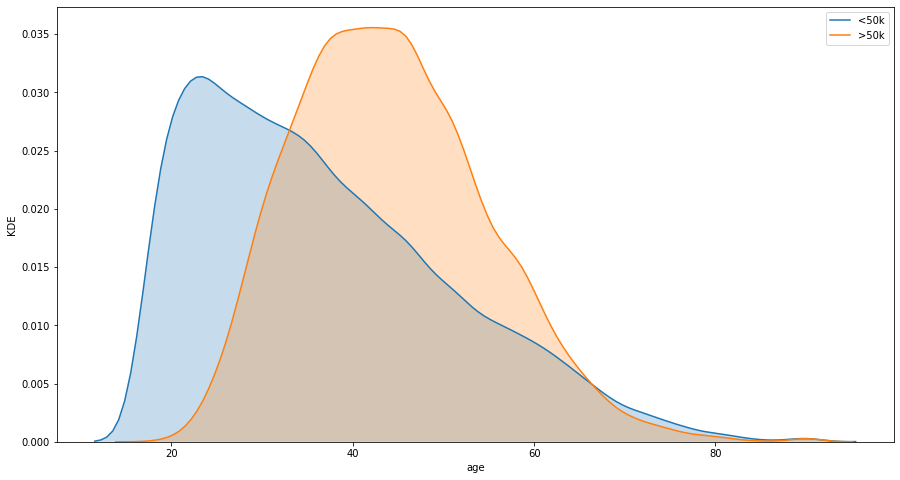

In [17]:
ax = sns.kdeplot(data['age'].where(data['over_50k']==0), shade=True)
sns.kdeplot(data['age'].where(data['over_50k']==1), shade=True)

ax.set_xlabel('age')
ax.set_ylabel('KDE')
ax.legend( labels=['<50k', '>50k'])
plt.show()

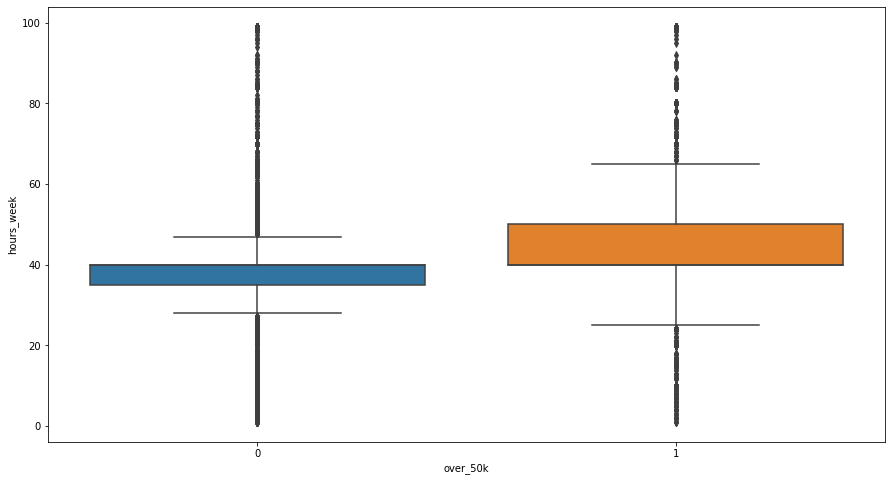

In [18]:
ax = sns.boxplot(x = data['over_50k'], y=data['hours_week'])
plt.show()

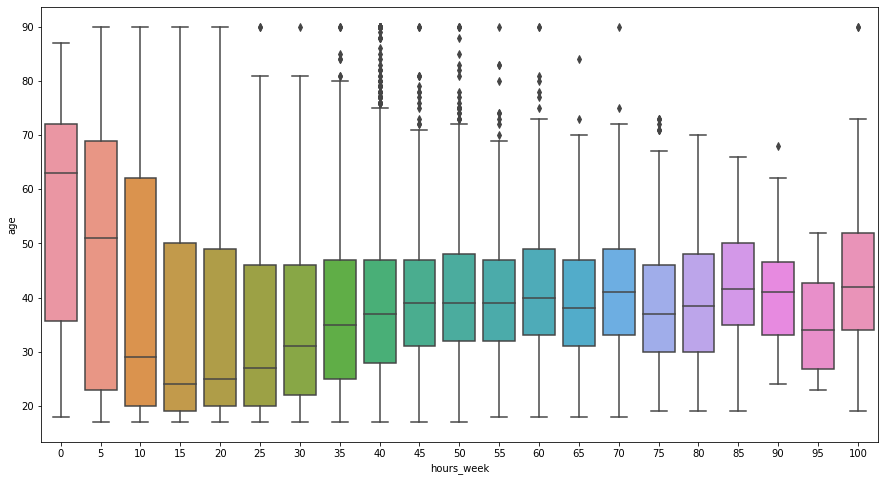

In [19]:
ax = sns.boxplot(x = data['hours_week'].apply(lambda x: round(x/5) * 5), y=data['age'])
plt.show()

In [20]:
# making new column for the US, non-US OECD high income, and non-US non-OECD high income
def label_marital_status(row):

    
    if row['marital_status_name'] in ['Married-civ-spouse', 'Married-AF-spouse']:
        return 'Married'
    else:
        return 'Single'

data['marital_status_label'] = data.apply(lambda row: label_marital_status(row), axis=1)

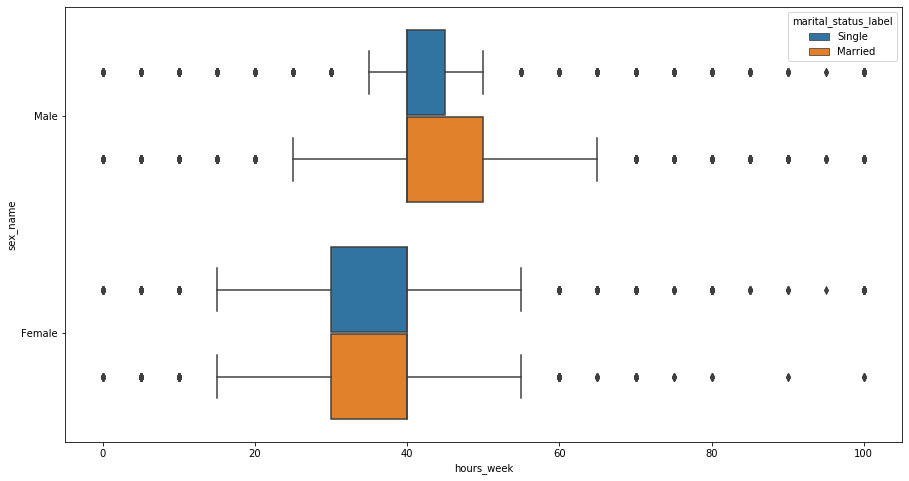

In [21]:
ax = sns.boxplot(x = data['hours_week'].apply(lambda x: round(x/5) * 5), y=data['sex_name'], hue=data['marital_status_label'])
plt.show()

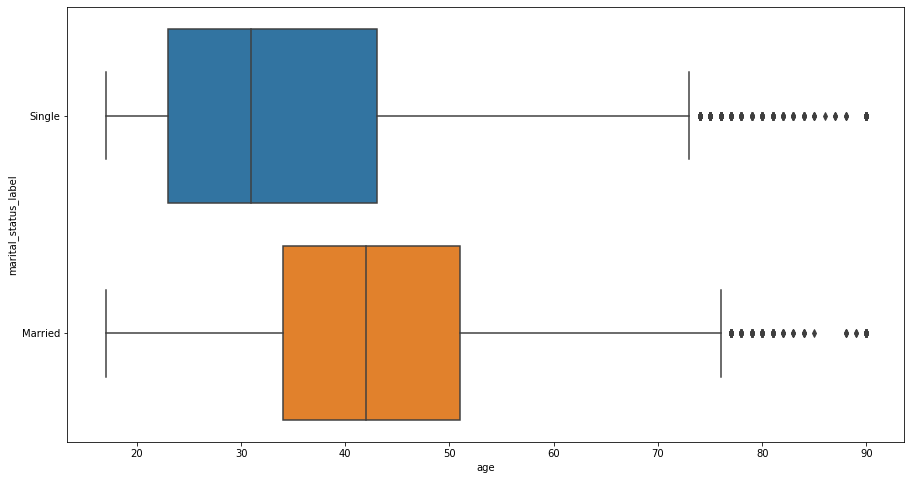

In [22]:
ax = sns.boxplot(x = data['age'], y=data['marital_status_label'])
plt.show()

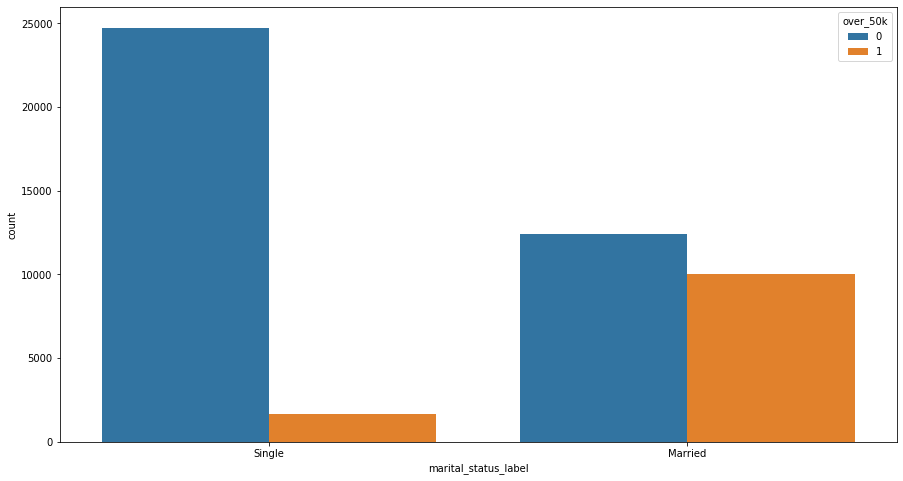

In [23]:
ax = sns.countplot(data['marital_status_label'], hue=data['over_50k'])

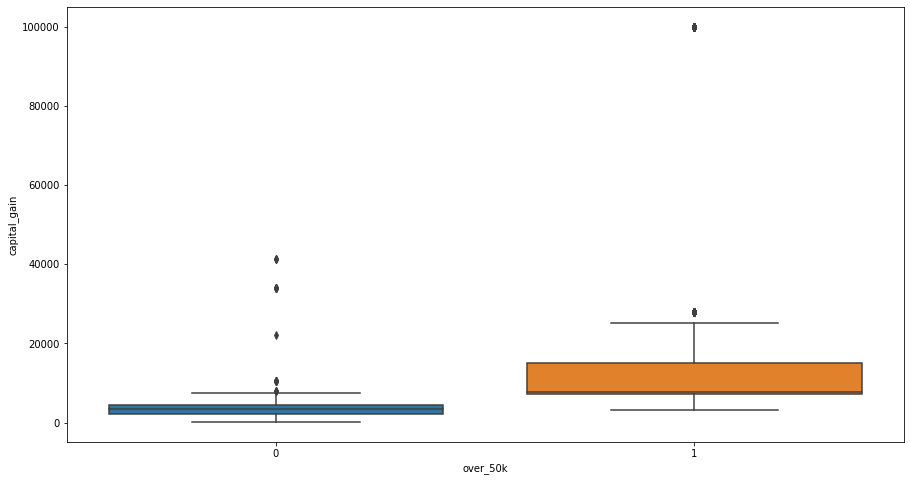

In [24]:
ax = sns.boxplot(x = data['over_50k'], y=data['capital_gain'].where(data['capital_gain']>0))
plt.show()

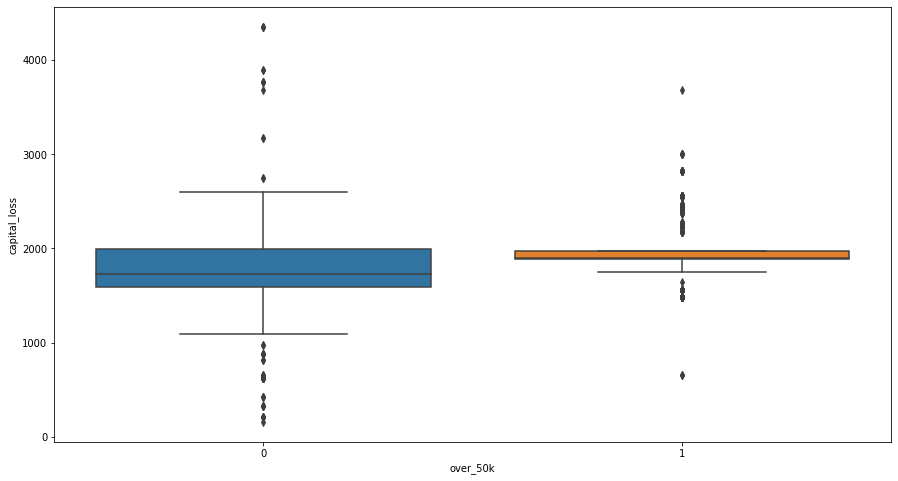

In [25]:
ax = sns.boxplot(x = data['over_50k'], y=data['capital_loss'].where(data['capital_loss']>0))
plt.show()

# Building Models

In [26]:
# reloading data
data = pd.read_csv('../data/exercise01.csv')
data = data.mask(data=='?', float('NaN'))

# imputing the mode for columns with missing data
imp = SimpleImputer(missing_values=float('NaN'), strategy='most_frequent')
data['workclass_name'] = imp.fit_transform(data[['workclass_name']]).ravel()
data['occupation_name'] = imp.fit_transform(data[['occupation_name']]).ravel()
data['country_name'] = imp.fit_transform(data[['country_name']]).ravel()

# checking that nulls have been imputer
null_counts = data.isnull().sum(axis=1)
print(f'{sum(null_counts.mask(null_counts > 0, 1))} rows with 1 or more null values, or {sum(null_counts.mask(null_counts > 0, 1))/len(data)*100}% of dataset.')

# scaling the larger continuous variables
scaler = StandardScaler()
data['capital_gain'] = scaler.fit_transform(data[['capital_gain']])
data['capital_loss'] = scaler.fit_transform(data[['capital_loss']])

# applying flags and binning
data['marital_status_label'] = data.apply(lambda row: label_marital_status(row), axis=1)
data['country_label'] = data.apply(lambda row: label_country(row), axis=1)
data['ages_binned'] = data['age'].apply(lambda x: round(x/5)*5)
data['hours_week_binned'] = data['hours_week'].apply(lambda x: round(x/10)*10)

# one hot encoding categorical variables
data = pd.concat([data, pd.get_dummies(data['workclass_name'], prefix='workclass_name')],axis=1).drop(['workclass_name'],axis=1)
data = pd.concat([data, pd.get_dummies(data['occupation_name'], prefix='occupation_name')],axis=1).drop(['occupation_name'],axis=1)
data = pd.concat([data, pd.get_dummies(data['sex_name'], prefix='sex_name')],axis=1).drop(['sex_name'],axis=1)
data = pd.concat([data, pd.get_dummies(data['marital_status_label'], prefix='marital_status_label')],axis=1).drop(['marital_status_label'],axis=1)
data = pd.concat([data, pd.get_dummies(data['country_label'], prefix='country_label')],axis=1).drop(['country_label'],axis=1)

data.columns

0 rows with 1 or more null values, or 0.0% of dataset.


Index(['id', 'age', 'workclass_id', 'education_level_id',
       'education_level_name', 'education_num', 'marital_status_id',
       'marital_status_name', 'occupation_id', 'relationship_id',
       'relationship_name', 'race_id', 'race_name', 'sex_id', 'capital_gain',
       'capital_loss', 'hours_week', 'country_id', 'country_name', 'over_50k',
       'ages_binned', 'hours_week_binned', 'workclass_name_Federal-gov',
       'workclass_name_Local-gov', 'workclass_name_Never-worked',
       'workclass_name_Private', 'workclass_name_Self-emp-inc',
       'workclass_name_Self-emp-not-inc', 'workclass_name_State-gov',
       'workclass_name_Without-pay', 'occupation_name_Adm-clerical',
       'occupation_name_Armed-Forces', 'occupation_name_Craft-repair',
       'occupation_name_Exec-managerial', 'occupation_name_Farming-fishing',
       'occupation_name_Handlers-cleaners',
       'occupation_name_Machine-op-inspct', 'occupation_name_Other-service',
       'occupation_name_Priv-house-serv

In [27]:
target = ['over_50k']

# list containing only features to be used in the model
features = ['education_num','ages_binned', 'capital_gain', 'capital_loss',
       'hours_week_binned', 'workclass_name_Federal-gov',
       'workclass_name_Local-gov', 'workclass_name_Never-worked',
       'workclass_name_Private', 'workclass_name_Self-emp-inc',
       'workclass_name_Self-emp-not-inc', 'workclass_name_State-gov',
       'workclass_name_Without-pay', 'occupation_name_Adm-clerical',
       'occupation_name_Armed-Forces', 'occupation_name_Craft-repair',
       'occupation_name_Exec-managerial', 'occupation_name_Farming-fishing',
       'occupation_name_Handlers-cleaners',
       'occupation_name_Machine-op-inspct', 'occupation_name_Other-service',
       'occupation_name_Priv-house-serv', 'occupation_name_Prof-specialty',
       'occupation_name_Protective-serv', 'occupation_name_Sales',
       'occupation_name_Tech-support', 'occupation_name_Transport-moving',
       'sex_name_Female', 'sex_name_Male', 'marital_status_label_Married',
       'marital_status_label_Single', 'country_label_US',
       'country_label_non-US OECD', 'country_label_non-US non-OECD']

# subsetting
X = data[features]
y = data[target]

# creating train, test, holdout datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, random_state=RANDOM_STATE)

# 2.0 Baseline Model

In [28]:
# baseline model - guessing 0 for all targets
print(f'{y_train["over_50k"].value_counts()[0]/len(y_train) * 100}% Accuracy guessing 0 for all rows - train')
print(f'{y_test["over_50k"].value_counts()[0]/len(y_test) * 100}% Accuracy guessing 0 for all rows - test')
print(f'{y_val["over_50k"].value_counts()[0]/len(y_val) * 100}% Accuracy guessing 0 for all rows - holdout')

76.14050802994433% Accuracy guessing 0 for all rows - train
75.92384072064694% Accuracy guessing 0 for all rows - test
75.98208573256558% Accuracy guessing 0 for all rows - holdout


# 2.1 Logistic Regression Model

In [49]:
clf = LogisticRegression()

# params = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
# grid = GridSearchCV(clf, params, cv=12, scoring = 'accuracy', verbose=1)
# grid.fit(X_train, y_train)
# best params found to be default

clf.fit(X_train, y_train)
pickle.dump(clf, open('../models/LinearRegression_Model.p', 'wb'))

0.850406295988227% accuracy for train data
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     23800
           1       0.73      0.59      0.65      7458

    accuracy                           0.85     31258
   macro avg       0.81      0.76      0.78     31258
weighted avg       0.84      0.85      0.84     31258



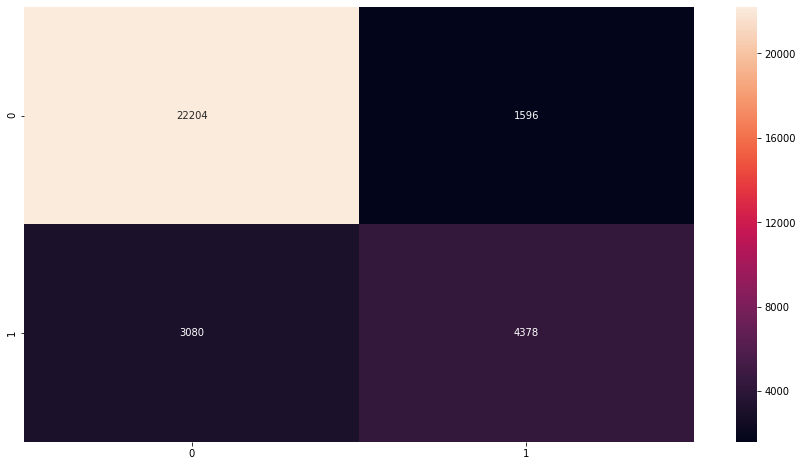

In [30]:
print(f'{clf.score(X_train, y_train)}% accuracy for train data')
print(classification_report(y_train, clf.predict(X_train)))

preds_test = clf.predict(X_test)

preds_val = clf.predict(X_val)

ax = sns.heatmap(confusion_matrix(y_train,  clf.predict(X_train)), annot=True, fmt='g')

0.8451223257242297% accuracy for test data
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      7417
           1       0.73      0.57      0.64      2352

    accuracy                           0.85      9769
   macro avg       0.80      0.75      0.77      9769
weighted avg       0.84      0.85      0.84      9769



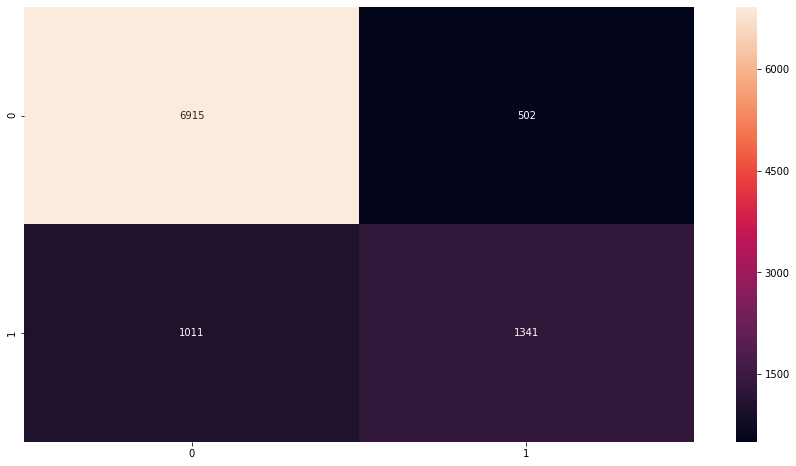

In [31]:
ax = sns.heatmap(confusion_matrix(y_test, preds_test), annot=True, fmt='g')
print(f'{accuracy_score(y_test, preds_test)}% accuracy for test data')
print(classification_report(y_test, preds_test))

0.8499040307101727% accuracy for test data
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      5938
           1       0.74      0.58      0.65      1877

    accuracy                           0.85      7815
   macro avg       0.81      0.76      0.78      7815
weighted avg       0.84      0.85      0.84      7815



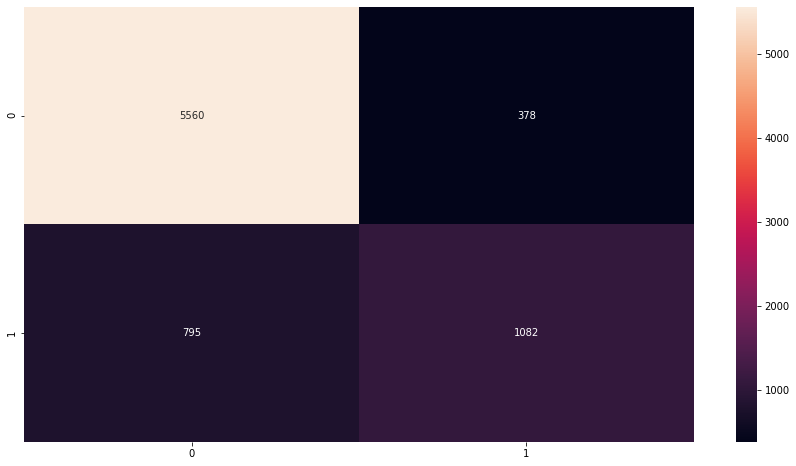

In [33]:
ax = sns.heatmap(confusion_matrix(y_val, preds_val), annot=True, fmt='g')
print(f'{accuracy_score(y_val, preds_val)}% accuracy for test data')
print(classification_report(y_val, preds_val))

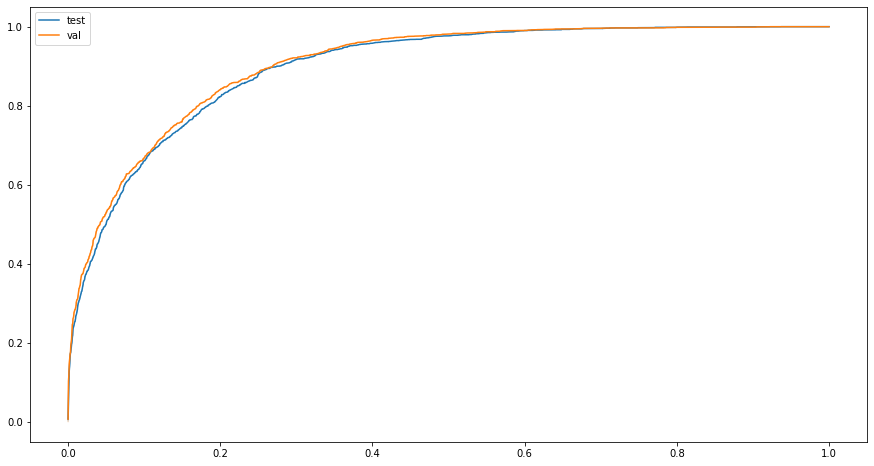

In [34]:
# get confidence scores from samples
conf_scores_test = clf.fit(X_train, y_train).decision_function(X_test)

#calculating fpr, tpr to plot
fpr, tpr, thresholds = roc_curve(y_test, conf_scores_test)
ax = sns.lineplot(fpr, tpr, )

conf_scores_val = clf.fit(X_train, y_train).decision_function(X_val)

fpr,tpr, thresholds = roc_curve(y_val, conf_scores_val)
sns.lineplot(fpr, tpr, )

ax.legend( labels=['test', 'val'])

plt.show()

In [35]:
print(f'{roc_auc_score(y_test, conf_scores_test)} AUC for test')
print((f'{roc_auc_score(y_val, conf_scores_val)} AUC for val'))

0.8977866392613402 AUC for test
0.9040363905984283 AUC for val


# 2.2 Random Forest Model

In [50]:
rf = RandomForestClassifier(random_state = RANDOM_STATE, n_estimators=1000, max_depth=8)

# params = { 
#     'n_estimators': [200, 500, 1000],
#     'max_features': ['sqrt', 'log2'],
#     'max_depth' : [2,4,6,8],
#     'criterion' :['gini', 'entropy']
# }

# grid = GridSearchCV(rf, params)
# grid.fit(X_train, y_train)

pickle.dump(clf, open('../models/RandomForest_Model.p', 'wb'))

In [37]:
rf.fit(X_train, y_train)
print(f'{rf.score(X_train, y_train)} mean accuracy for train')
print(f'{rf.score(X_test, y_test)} mean accuracy for test')
print(f'{rf.score(X_val, y_val)} mean accuracy for val')

0.8634589545076461 mean accuracy for train
0.8582249974408844 mean accuracy for test
0.8632117722328855 mean accuracy for val


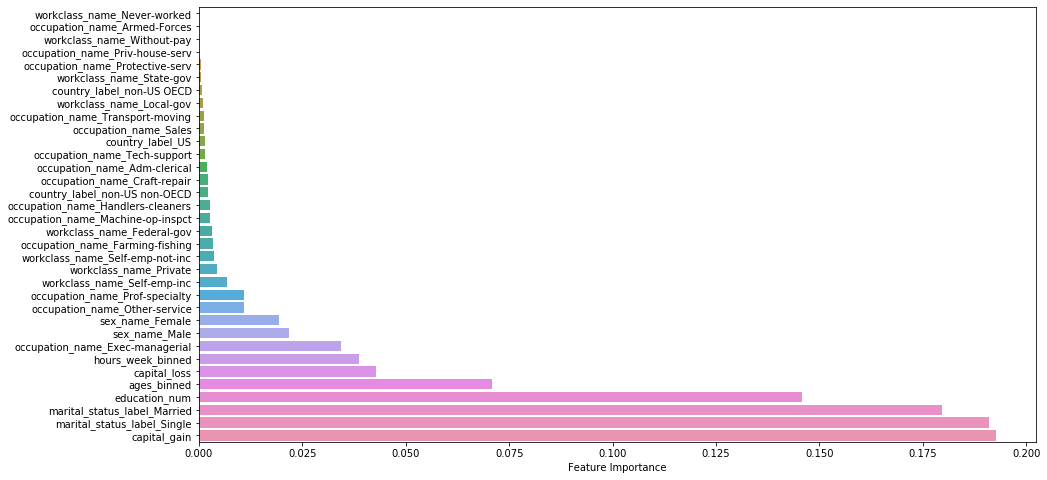

In [38]:
f_importances = rf.feature_importances_
# getting sorted indexes of f_importance
idx = np.argsort(f_importances)

sns.barplot(f_importances[idx], list(range(len(idx))), orient='h')
plt.yticks(range(len(idx)), [features[i] for i in idx])
plt.xlabel('Feature Importance')
plt.show()

# 2.2 XGBoost Model

In [39]:
import xgboost as xgb

In [51]:
xgbm = xgb.XGBClassifier(n_estimators=750, min_child_weight=5, max_depth=5, 
                         early_stopping=10, gamma=.1, seed=RANDOM_STATE)
pickle.dump(clf, open('../models/XGB_Model.p', 'wb'))
xgbm

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping=10,
              gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=750, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=90617,
              silent=None, subsample=1, verbosity=1)

In [41]:
xgbm.fit(X_train, y_train)
print(f'{accuracy_score(y_train, xgbm.predict(X_train))}% accuracy for test data')
print(classification_report(y_train,xgbm.predict(X_train)))

0.8843176146906392% accuracy for test data
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     23800
           1       0.80      0.69      0.74      7458

    accuracy                           0.88     31258
   macro avg       0.85      0.82      0.83     31258
weighted avg       0.88      0.88      0.88     31258



In [42]:
print(f'{accuracy_score(y_test, xgbm.predict(X_test))}% accuracy for test data')
print(classification_report(y_test,xgbm.predict(X_test)))

0.8725560446309756% accuracy for test data
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7417
           1       0.78      0.65      0.71      2352

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



In [43]:
print(f'{accuracy_score(y_val, xgbm.predict(X_val))}% accuracy for test data')
print(classification_report(y_val,xgbm.predict(X_val)))

0.873576455534229% accuracy for test data
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      5938
           1       0.78      0.66      0.71      1877

    accuracy                           0.87      7815
   macro avg       0.84      0.80      0.82      7815
weighted avg       0.87      0.87      0.87      7815



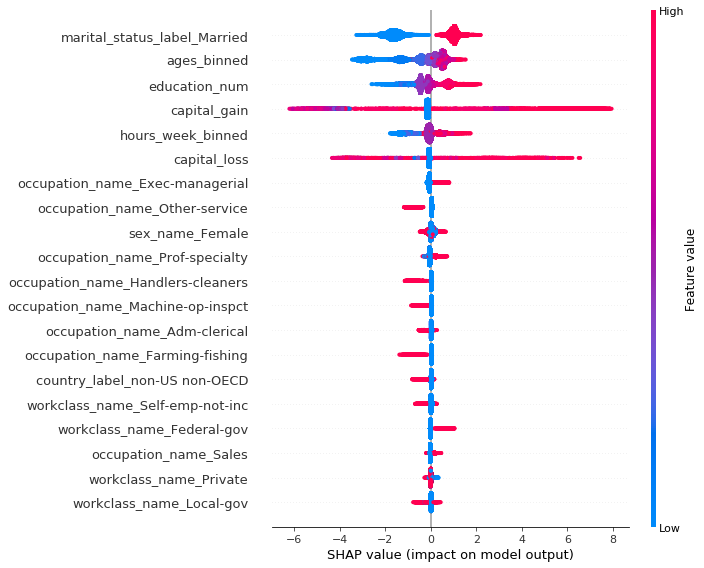

In [44]:
# graph of shap values - ordered by overall feature importance according to docs
shap_values = shap.TreeExplainer(xgbm).shap_values(X)
shap.summary_plot(shap_values, X)